In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import shap
import missingno as msno


from datetime import datetime
from catboost import Pool, CatBoostRegressor, EShapCalcType, EFeaturesSelectionAlgorithm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [2]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv')

df_test = pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv')

df_train.columns

Index(['id', 'Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Policy Start Date',
       'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
       'Property Type', 'Premium Amount'],
      dtype='object')

# Data exploration - what did one do to deserve such premiums?

In [3]:
pd.set_option('display.max_columns', None)
df_train.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [4]:
df_train['Health Score'].dropna().astype(int).nunique()

57

In [5]:
# Percentages of missing rows per column
df_train.isna().mean().mul(100)

id                       0.000000
Age                      1.558750
Gender                   0.000000
Annual Income            3.745750
Marital Status           1.544083
Number of Dependents     9.139333
Education Level          0.000000
Occupation              29.839583
Health Score             6.173000
Location                 0.000000
Policy Type              0.000000
Previous Claims         30.335750
Vehicle Age              0.000500
Credit Score            11.490167
Insurance Duration       0.000083
Policy Start Date        0.000000
Customer Feedback        6.485333
Smoking Status           0.000000
Exercise Frequency       0.000000
Property Type            0.000000
Premium Amount           0.000000
dtype: float64

<Figure size 1000x600 with 0 Axes>

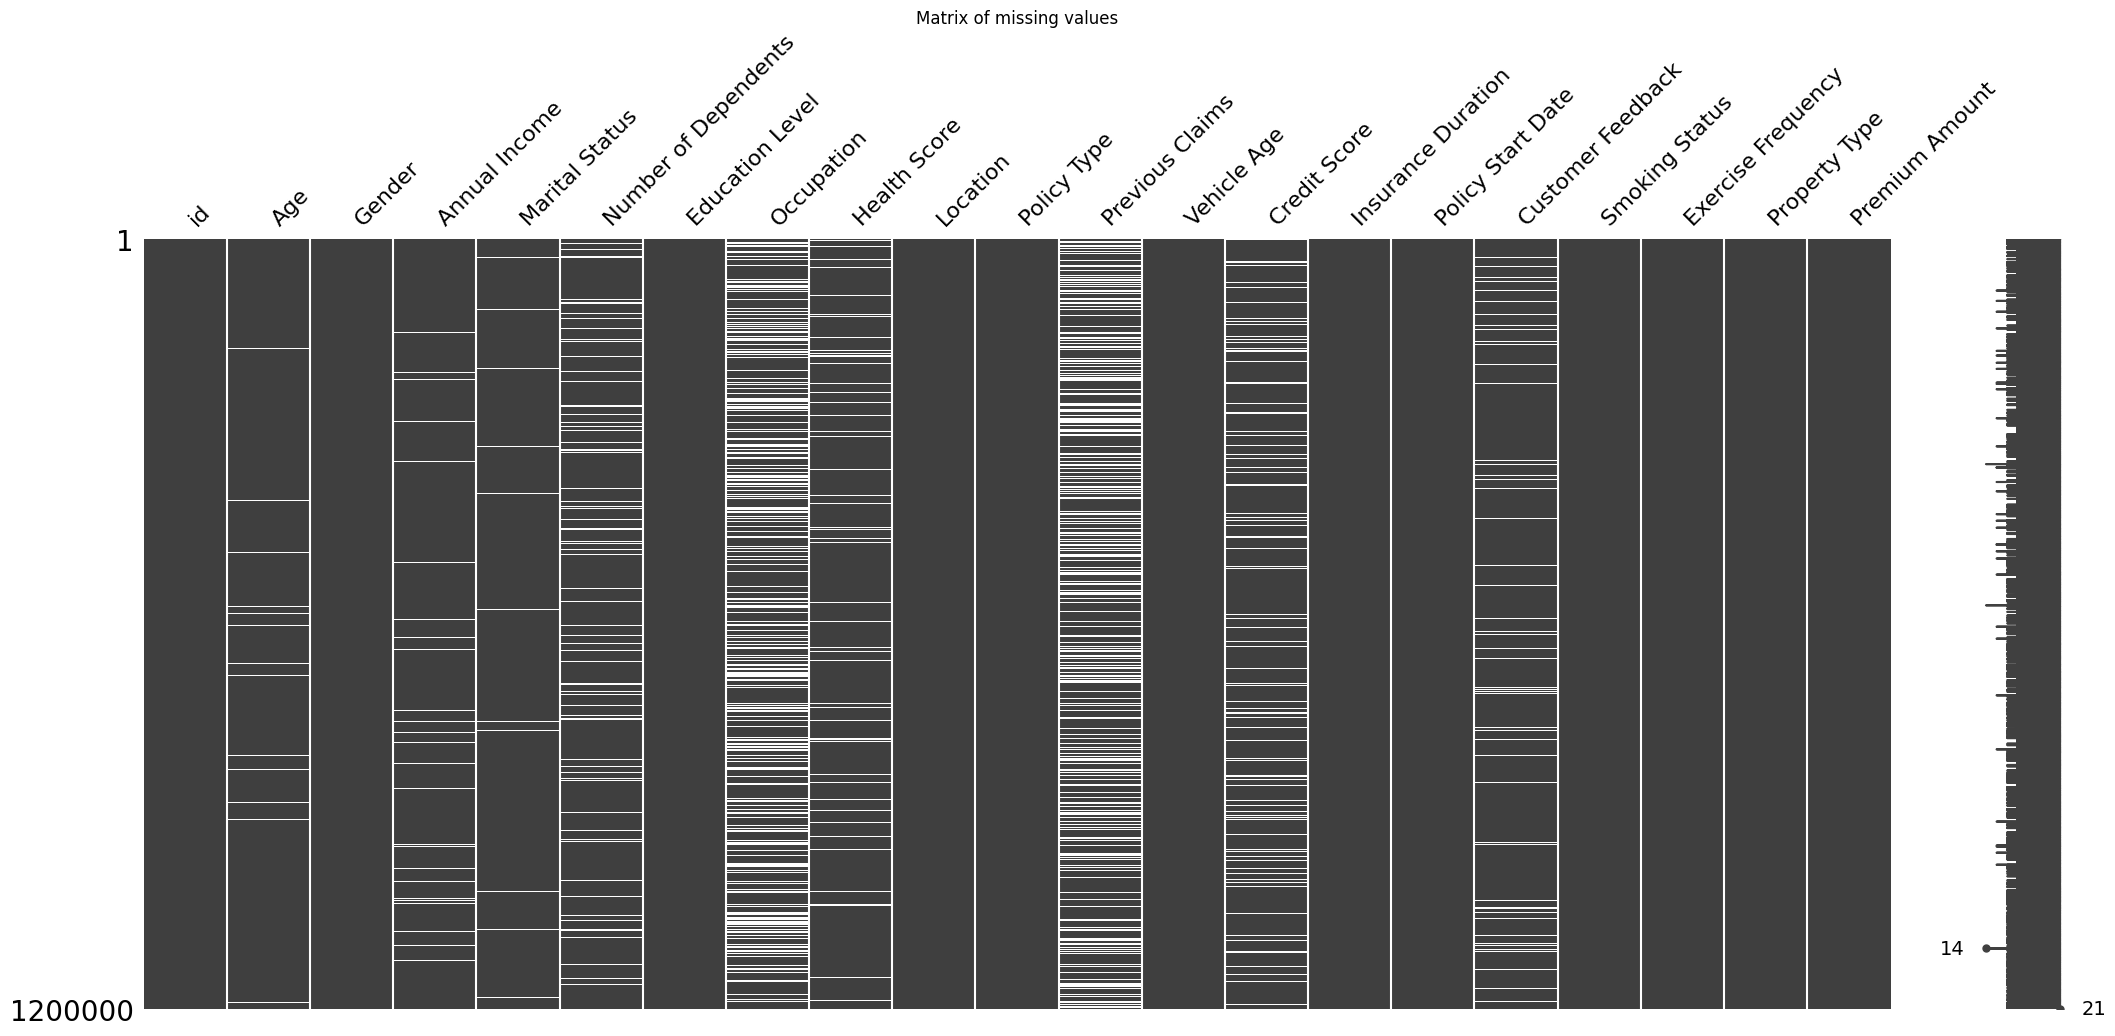

In [6]:
# Creating a matrix of missing data
plt.figure(figsize=(10, 6))
msno.matrix(df_train)
plt.title('Matrix of missing values')
plt.show()

In [7]:
df_train['Health Score'].value_counts()

Health Score
19.927241    128
25.907650    124
19.869701    119
22.955402    104
27.845006    103
            ... 
7.442964       1
4.551825       1
31.391907      1
41.376716      1
20.717076      1
Name: count, Length: 532657, dtype: int64

**What's missing?**

Missing data doesn't appear to be concentrated in single rows, but spread out. Even so, number of missing values per row might hold valuable information.

**How unique are our features?**

Too many categories can impair training speed and may bring nothing to the table if they have a low count. Shall we take a look?

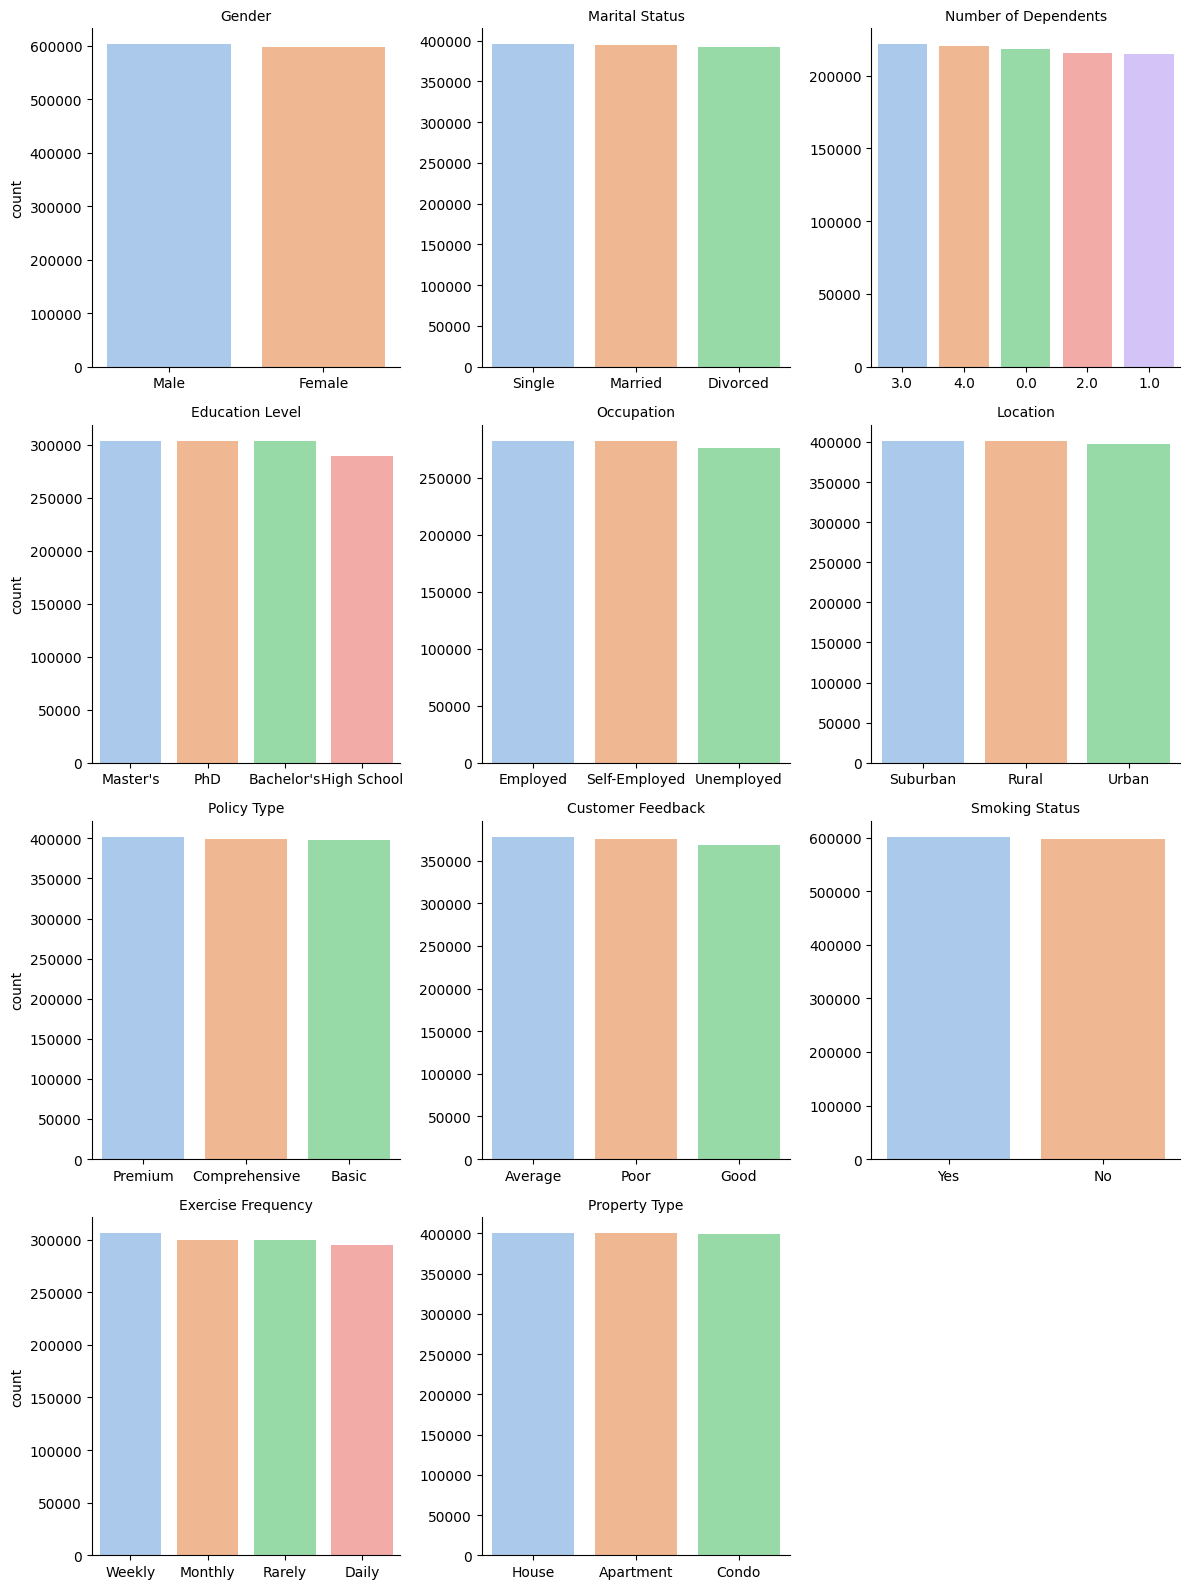

In [8]:
numerical_vars = ['Age', 'Annual Income', 'Health Score',
                  'Previous Claims', 'Vehicle Age', 'Credit Score',
                  'Insurance Duration', 'Premium Amount']



# Melting the dataframe
melted_cats = df_train.drop(['id', 'Policy Start Date']+numerical_vars,
                            axis =1).melt(var_name='Feat', value_name='Cat')

fg = sns.FacetGrid(melted_cats, col='Feat', col_wrap=3, height=4, sharex=False, sharey=False)


# Mapping bar plots to a grid
def plot_feature(data, **kwargs):
    feature = data['Feat'].iloc[0]  # Get the current feature being plotted
    sns.countplot(data=data, x='Cat', order=data['Cat'].value_counts().index, **kwargs, palette = 'pastel')

fg.map_dataframe(plot_feature)

# Plot adjustments
fg.set_axis_labels(x_var='', y_var='count')
fg.set_titles("{col_name}")
fg.tight_layout()
plt.show()

The number of unique values across all features is consistent, with each feature having a similar or identical count of distinct categories.

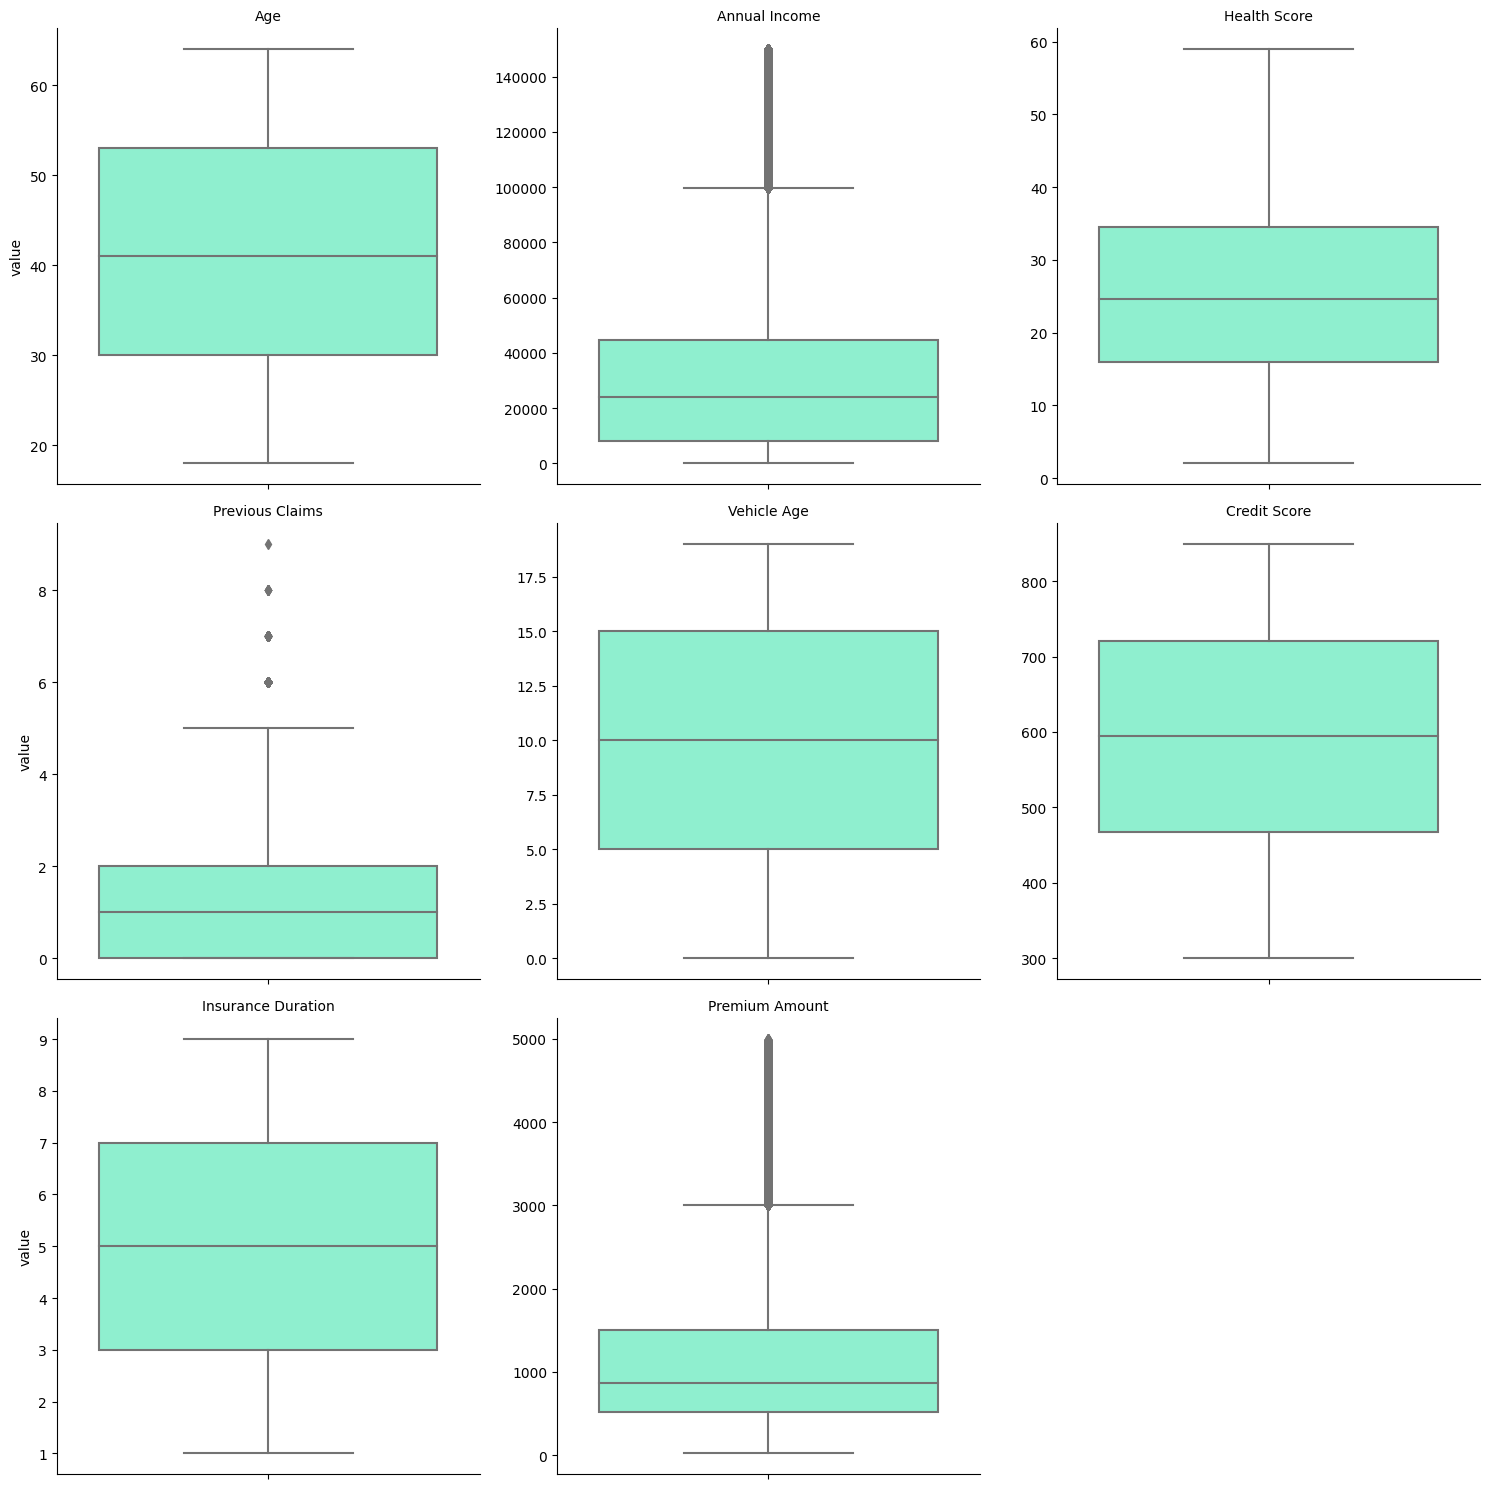

In [9]:
melted_nums = df_train[numerical_vars].melt(var_name='Feat',
                                            value_name='Value')

# Create a FacetGrid for box plots
fg = sns.FacetGrid(melted_nums, col='Feat', col_wrap=3, height=5, sharey=False)

# Mapping box plots to the grid
fg.map_dataframe(sns.boxplot, y='Value', color='aquamarine')

# Plot adjustments
fg.set_axis_labels(x_var='', y_var='value')
fg.set_titles("{col_name}")
fg.tight_layout()
plt.show()

*Actual Income*, *Previous Claims* and *Premium Amount* have visible outliers and also are not symmetrical. Apart from these features *Health Score* shows signs of its distribution being right skewed.

**Affecting Premium Amounts**

It's worth taking a look how insurance duration and previous claim interact with each other, as well as the Premium Amount.

Text(0.5, 1.0, 'Premium Amount based on its duration and number of claims')

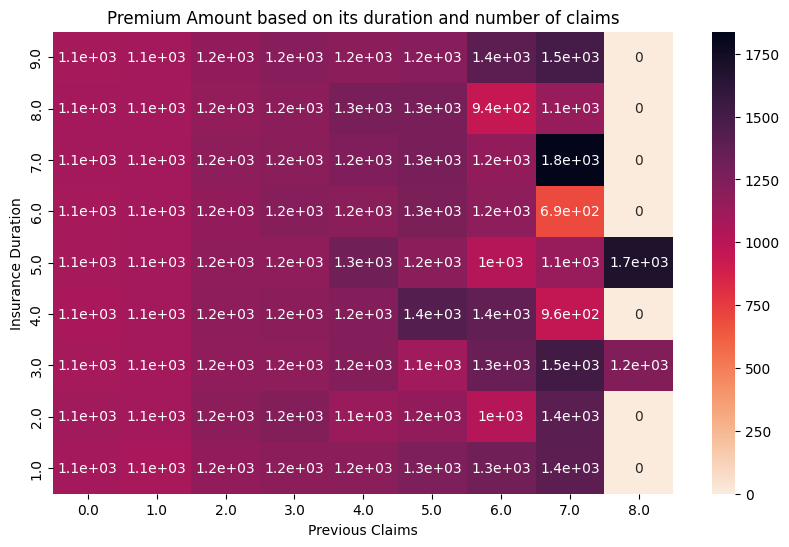

In [10]:
work_ps = df_train.dropna().pivot_table(
    index='Insurance Duration',  
    columns= 'Previous Claims',  
    values='Premium Amount',
    aggfunc='mean', 
    fill_value=0
)


plt.figure(figsize=(10, 6))
sns.heatmap(work_ps, annot=True, cmap="rocket_r", cbar=True).invert_yaxis()
plt.title('Premium Amount based on its duration and number of claims')

*Previous Claims* have a stronger effect on the *Premium Amount* than the duration of insurance. Nevertheless, longer duration can also mean more time for a possible claim to happen. A ratio of claims vs duration could be useful for training a model.

**Missing values in *Occupation***

Since *Occupation* has the second most misisng rows, it's worth checking if the data can be imputed by predicting with other existing features. First the relation between *Annual Income* and *Occupation*.

In [11]:
df_train.groupby("Occupation")['Annual Income'].agg(['mean', 'median'])

,mean,median
Occupation,,
Employed,32747.057259,23961.0
Self-Employed,32909.187329,23961.0
Unemployed,32864.541820,23962.0


It seems that the *Occupation* variable is not that easy to impute from *Annual Income* - all occupations, more or less, have the same earnings.

In [12]:
df_train.groupby("Occupation")['Premium Amount'].mean()

Occupation
Employed         1107.400895
Self-Employed    1106.609284
Unemployed       1105.369023
Name: Premium Amount, dtype: float64

They also pay the same premiums.

# Preparing data for training

After checking [Backpacker's notebook](https://www.kaggle.com/code/backpaker/rid-catboost-nonlog) I wondered what the reason was for score discrepency. Was it hyperparameters, feature engineering or use of an entirely different model? Apparently, during the fitting of a CatBoostRegressor model it is imperative to assign *Health Score* to [cat_features](https://catboost.ai/docs/en/concepts/python-reference_catboostregressor).

Thanks to this little change, mean scores for cv went from around 1.04 to 1.03-ish.

Another thing came to attention after creating a variable by mistake. *HealthScore* made from *Health Score* and transformed into an integer then into string, achieved lower scores in the absence of *Health Score* variable. What was surprising, the cv scores got better when both variables (this time *HealtScore* is an integer and *Health Score* a string) were introduced to the model.

In [13]:
def feature_changer(df):

    global numerical_vars
    vars = numerical_vars.copy()

    vars = [var for var in vars if var not in ['Health Score', 'Previous Claims']]
    if 'Premium Amount' in vars:
      vars.remove('Premium Amount')


    # Counter for missing values per row
    df['MissingValuesCount'] = df.isna().sum(axis=1)
    df['MissingHealth'] = df['Health Score'].isna().astype(int)
    # Number of days passed between last policy started and current policy
    df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])

    df['Days Passed'] = (df['Policy Start Date'].max() - df['Policy Start Date']).dt.days
    df['Year'] = df['Policy Start Date'].dt.year
    df['Day'] = df['Policy Start Date'].dt.day
    df['Month'] = df['Policy Start Date'].dt.month

    # Creating Ratio variables, as well as categorizing continuous ones
    df['Claims v Duration'] = df['Previous Claims'] / df['Insurance Duration']
    df['Health vs Claims'] = df['Health Score'] / df['Previous Claims']
    df['Cat Credit Score'] = df['Credit Score'].copy()
    df['Int Credit Score'] = df['Credit Score'].apply(lambda x: int(x) if pd.notna(x) else x)
    df['Int Annual Income'] = df['Annual Income'].apply(lambda x: int(x) if pd.notna(x) else x)
    vars+= ['Days Passed']
    cats = [col for col in df.columns if col not in vars]

    # Filling missing data
    df['HealthScore'] = df['Health Score'].apply(lambda x: int(x) if pd.notna(x) else x)
    df[cats] = df[cats].fillna('None').astype('string')
    df[vars] = df[vars].fillna(0).astype(float)

    df = df.drop(['id', 'Policy Start Date'], axis = 1)

    return df

**Adding multiple variables as categorical and continuous ones**

Decided to experiment with creating copies of variables and converting them to strings so they could pass as cat_features. CV improved but the whole process also became more computationally expensive.

In [14]:
X, y = df_train.drop('Premium Amount', axis=1), df_train['Premium Amount']

X = feature_changer(X)

# Taking first steps towards shaping and training data

In [18]:
class CatBoostAndOptunaParams:
    def __init__(self,
                 X,
                 y,
                 n_folds=10,
                 hyperparam_bounds=None,
                 random_state=42,
                 task_type='GPU',
                 verbose=0):
        self.X = X
        self.y = y
        self.n_folds = n_folds
        self.random_state = random_state
        self.task_type = task_type
        self.verbose = verbose
        self.hyperparam_bounds = hyperparam_bounds or {
            'iterations': (500,700),
            'depth': (7, 9),
            'learning_rate': (0.05, 0.2),
            'l2_leaf_reg': (0.3, 1.0),
            'loss_function': ['RMSE']
        }

        # Placeholders
        self.hyperparams_history = []
        self._oof_predictions = []
        self.best_score = float('inf')

    def _suggest_hyperparams(self, trial):
        return {
            'iterations': trial.suggest_int('iterations', *self.hyperparam_bounds['iterations']),
            'depth': trial.suggest_int('depth', *self.hyperparam_bounds['depth']),
            'learning_rate': trial.suggest_float('learning_rate', *self.hyperparam_bounds['learning_rate'], log=True),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', *self.hyperparam_bounds['l2_leaf_reg'], log=True),
            'loss_function': trial.suggest_categorical('loss_function', self.hyperparam_bounds['loss_function'])
        }


    def objective(self, trial):

        params = self._suggest_hyperparams(trial)

        # Assigning string type variables to cat_features for fitting
        cat_features = [col for col in self.X.select_dtypes(include=['object', 'string']).columns]

        # K-Fold cross-validation
        folds = KFold(n_splits=self.n_folds, shuffle = True, random_state=self.random_state)
        fold_rmsle = []
        oof_preds = np.zeros(len(self.y))


        for fold, (train_idx, val_idx) in enumerate(folds.split(self.X, self.y)):
            X_train, y_train = self.X.iloc[train_idx], self.y.iloc[train_idx]
            X_val, y_val = self.X.iloc[val_idx], self.y.iloc[val_idx]

            # Model creation and training
            model = CatBoostRegressor(
                iterations=params['iterations'],
                depth=params['depth'],
                learning_rate=params['learning_rate'],
                loss_function=params['loss_function'],
                random_state=self.random_state,
                l2_leaf_reg=params['l2_leaf_reg'],
                task_type=self.task_type,
                verbose=self.verbose
            )
            model.fit(X_train, y_train, cat_features=cat_features)


            val_pred = model.predict(X_val)
            val_pred = np.maximum(0, val_pred) # Clipping prediction values

            # Getting oof predictions
            oof_preds[val_idx] = val_pred


            fold_rmsle.append(mean_squared_error(y_val, val_pred, squared = False))

        # Saving oof predictions
        self._oof_predictions.append(oof_preds.copy())


        # Calculating mean rmsle across folds
        mean_rmsle = np.mean(fold_rmsle)

        self.hyperparams_history.append({**params, 'RMSE': mean_rmsle})
        return mean_rmsle

    def optimize(self, n_trials=5, direction="minimize"):
        study = optuna.create_study(direction=direction)
        study.optimize(self.objective, n_trials=n_trials)
        self.best_params = study.best_params
        self.best_value = study.best_value
        return study

    @property
    def oof(self):
        if self._oof_predictions is None:
            raise ValueError("No OOF predictions available")
        return self._oof_predictions

    @property
    def history(self):
        if not self.hyperparams_history:
            raise ValueError("No hyperparameter history available")
        self.hyperparams_history = sorted(self.hyperparams_history, key=lambda x: x['RMSE'])
        return self.hyperparams_history 

**OOF Predictions**

Out-of-fold predictins come from each trial and then an average of results is taken.

In [19]:
y_log1p = np.log1p(y)

hyperparam_search = CatBoostAndOptunaParams(X, y_log1p, n_folds = 5)
first_study = hyperparam_search.optimize(n_trials=5)

[I 2024-12-15 14:45:41,820] A new study created in memory with name: no-name-11b95ccf-a2c2-40bb-b03b-449097ece6ac
[I 2024-12-15 14:52:35,723] Trial 0 finished with value: 1.0328769558129975 and parameters: {'iterations': 550, 'depth': 7, 'learning_rate': 0.08072241049179459, 'l2_leaf_reg': 0.37769706719091256, 'loss_function': 'RMSE'}. Best is trial 0 with value: 1.0328769558129975.
[I 2024-12-15 14:59:29,469] Trial 1 finished with value: 1.0328017643006535 and parameters: {'iterations': 546, 'depth': 7, 'learning_rate': 0.10160380887188143, 'l2_leaf_reg': 0.6112934041429208, 'loss_function': 'RMSE'}. Best is trial 1 with value: 1.0328017643006535.
[I 2024-12-15 15:06:14,945] Trial 2 finished with value: 1.0331290285796246 and parameters: {'iterations': 531, 'depth': 7, 'learning_rate': 0.05698298343515767, 'l2_leaf_reg': 0.6910854245732895, 'loss_function': 'RMSE'}. Best is trial 1 with value: 1.0328017643006535.
[I 2024-12-15 15:14:24,790] Trial 3 finished with value: 1.0338499276254

In [20]:
oof_preds = hyperparam_search.oof

#Sum of predictions from all trials
mean_squared_log_error(y, sum(np.expm1(oof_preds))/len(oof_preds), squared = False)

1.0323656294211432

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

y_train_log1p = np.log1p(y_train)
y_test_log1p = np.log1p(y_test)

cat_features = [col for col in X_train.select_dtypes(include=['object', 'string']).columns]

#Model on training data
model = CatBoostRegressor(
        **first_study.best_params,
        task_type = 'GPU',
        random_state=42,
        verbose = 0,
        cat_features=cat_features)


model.fit(X_train, y_train, cat_features = cat_features)

# Testing the efficacy of created models and making final predictions

In [22]:
shap.initjs()
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(Pool(X_train, y_train, cat_features=cat_features))
shap.force_plot(explainer.expected_value, shap_values[169,:], X_train.iloc[169,:])

In [23]:
shap.force_plot(explainer.expected_value, shap_values[196,:], X_train.iloc[196,:])

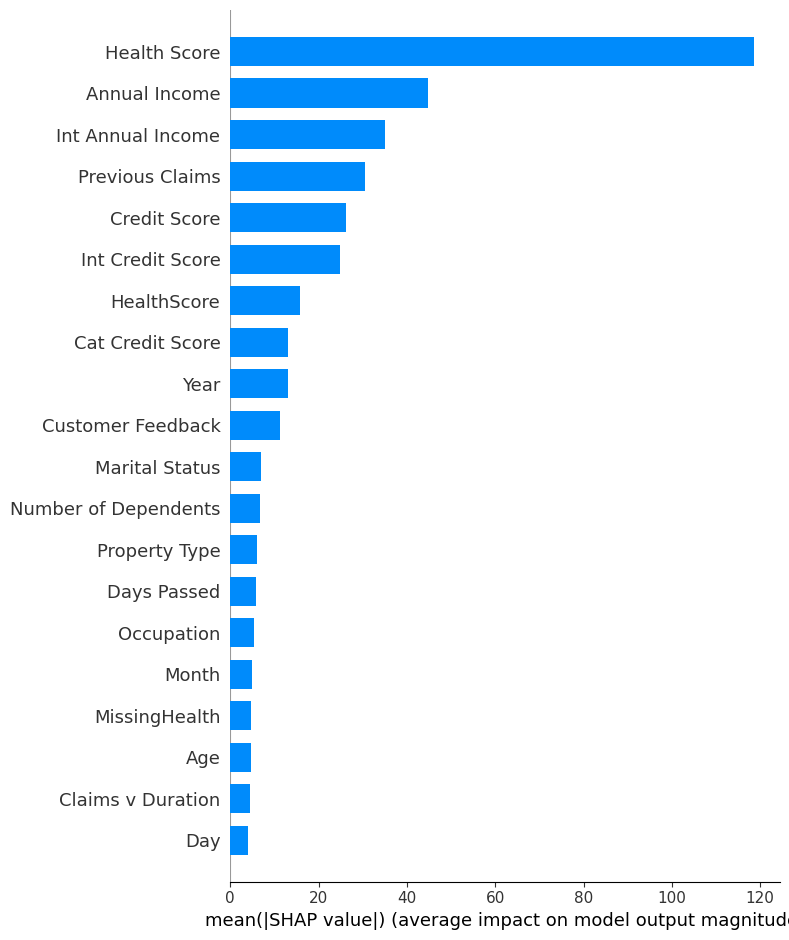

In [24]:
#Feature importance
shap.summary_plot(shap_values, X_train, plot_type="bar")

*Health Score* as a continuous variable doesn't have the same importance for CatBoost as a categorical one. Variable *HealthScore* that was created by a mistake, also boasts a higher importance than other features, despite the existance of original *Health Score*. *HealthScore* (which is *Health Score* transformed into an integer) has fewer unique values than *Health Score* so it might provide some information about cutoff points.

In [25]:
train_pool = Pool(X_train, y_train_log1p, feature_names = X_train.columns.tolist(), cat_features=cat_features)
test_pool = Pool(X_test, y_test_log1p, feature_names = X_test.columns.tolist(), cat_features=cat_features)


model = CatBoostRegressor(**first_study.best_params,
        random_state=42,
        task_type='GPU',
        verbose = 0,
        cat_features=cat_features)

summary = model.select_features(
    train_pool,
    eval_set=test_pool,
    features_for_select='0-29',
    num_features_to_select=14,
    steps=16,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True,
    logging_level='Silent',
    plot=False
)

summary

{'selected_features': [2, 3, 4, 7, 10, 12, 14, 16, 19, 21, 26, 27, 28, 29],
 'eliminated_features_names': ['Vehicle Age',
  'Age',
  'Insurance Duration',
  'Policy Type',
  'Smoking Status',
  'Gender',
  'Day',
  'Days Passed',
  'Location',
  'Education Level',
  'MissingValuesCount',
  'Property Type',
  'Month',
  'Claims v Duration',
  'Occupation',
  'Health vs Claims'],
 'loss_graph': {'main_indices': [0,
   1,
   3,
   4,
   5,
   6,
   7,
   9,
   10,
   10,
   11,
   12,
   13,
   14,
   15,
   15,
   16],
  'removed_features_count': [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16],
  'loss_values': [1.0329140920859805,
   1.032825145046268,
   1.032813119522088,
   1.0328032468403,
   1.0326790700195145,
   1.032634581868616,
   1.0326874007441214,
   1.0326480171261936,
   1.0325907019856873,
   1.0325866691482102,
   1.032619744238702,
   1.0324680571556029,
   1.0324063764117652,
   1.0324688320261044,
   1.032359

Trimming down the number of features bears some fruit, as the rmsle improves a tiny bit.

In [26]:
#Function for creating oof predictions (on test data)
def cv_test_preds(X, y, X_test, hyperparams, n_folds=5, random_state=42, task_type='GPU', verbose=0):

    folds = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    test_preds = []

    for fold, (train_idx, val_idx) in enumerate(folds.split(X, y)):

        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]

        # Finding categorical features
        cat_features = [col for col in X.select_dtypes(include=['object', 'string']).columns]


        model = CatBoostRegressor(
            iterations=hyperparams[0]['iterations'],
            depth=hyperparams[0]['depth'],
            learning_rate=hyperparams[0]['learning_rate'],
            loss_function=hyperparams[0]['loss_function'],
            random_state=random_state,
            l2_leaf_reg=hyperparams[0]['l2_leaf_reg'],
            task_type=task_type,
            verbose=verbose
        )
        model.fit(X_train, y_train, cat_features=cat_features)

        # Making predictions
        test_preds.append(model.predict(X_test))

    return test_preds

In [28]:
# Getting hyperparameters for cut data
X_selected = X.drop(summary['eliminated_features_names'], axis = 1)
hyperparam_search = CatBoostAndOptunaParams(X_selected, y_log1p,  n_folds = 5, 
                                           hyperparam_bounds = {
            'iterations': (500,700),
            'depth': (7, 8),
            'learning_rate': (0.05, 0.2),
            'l2_leaf_reg': (0.4, 1.0),
            'loss_function': ['RMSE']
        })


cut_study = hyperparam_search.optimize(n_trials=5)

print("Best Parameters:", cut_study.best_params)
print("Best RMSLE:", cut_study.best_value)

[I 2024-12-15 16:06:34,409] A new study created in memory with name: no-name-a4d5ec6b-ade8-46a7-b3f4-a5c9dd3a6864
[I 2024-12-15 16:10:59,340] Trial 0 finished with value: 1.032062339898811 and parameters: {'iterations': 505, 'depth': 8, 'learning_rate': 0.0903021474966321, 'l2_leaf_reg': 0.6608498697350708, 'loss_function': 'RMSE'}. Best is trial 0 with value: 1.032062339898811.
[I 2024-12-15 16:15:19,361] Trial 1 finished with value: 1.0322742381256234 and parameters: {'iterations': 553, 'depth': 7, 'learning_rate': 0.17550083108309855, 'l2_leaf_reg': 0.9180162206667052, 'loss_function': 'RMSE'}. Best is trial 0 with value: 1.032062339898811.
[I 2024-12-15 16:19:51,757] Trial 2 finished with value: 1.0324006473321659 and parameters: {'iterations': 592, 'depth': 7, 'learning_rate': 0.07001768964875509, 'l2_leaf_reg': 0.66393468532513, 'loss_function': 'RMSE'}. Best is trial 0 with value: 1.032062339898811.
[I 2024-12-15 16:24:31,245] Trial 3 finished with value: 1.0322616540100344 and 

Best Parameters: {'iterations': 505, 'depth': 8, 'learning_rate': 0.0903021474966321, 'l2_leaf_reg': 0.6608498697350708, 'loss_function': 'RMSE'}
Best RMSLE: 1.032062339898811


In [29]:
#Sum of predictions from all trials
oof_cut_preds = hyperparam_search.oof
mean_squared_log_error(y, sum(np.expm1(oof_cut_preds))/len(oof_cut_preds), squared = False)

1.0318222474469236

In [30]:
X_test = feature_changer(df_test)

X_final_preds = cv_test_preds(X_selected,
                              y_log1p,
                              X_test.drop(summary['eliminated_features_names'], axis =1),
                              hyperparam_search.history,
                              n_folds = 5)

preds = sum(np.expm1(X_final_preds))/len(X_final_preds)

In [31]:
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e12/sample_submission.csv')

sample_submission['Premium Amount'] = preds
sample_submission.to_csv("submission.csv", index = False)